<a href="https://colab.research.google.com/github/lflorian/sp1/blob/master/Lab05_0710082.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UNIVERSIDAD GALILEO**
# Laboratorio No. 05
## Luis Florian

### *Objetivos:*
Con un dataset de reviews de amazon, determinar si el review es positivo (rating de 4 o 5) o negativo (rating de 1 o 2).


# **Imports**

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, Conv1D, MaxPooling1D, GRU
from tensorflow.keras.models import Sequential

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import sqlite3
from tqdm import tqdm
import re
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

# **Dataset**
Amazon Food Reviews

In [7]:
conn = sqlite3.connect('/content/input/database.sqlite')
filtered_data = pd.read_sql_query(''' SELECT * FROM REVIEWS LIMIT 100000''', conn)

# Score>3 -> rating(1)
# Score<3 -> rating(0)

def partition(x):
    if x < 3:
        return 0
    return 1

def findMinorClassPoints(df):
    posCount = int(df[df['Score']==1].shape[0]);
    negCount = int(df[df['Score']==0].shape[0]);
    if negCount < posCount:
        return negCount
    return posCount

# Cambiar reviews con score menor a 3 a positivo y viceversa.

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch."


# **Procesamiento de la data**

In [8]:
#Ordenar la data por ProductID ascendentemente
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Entradas duplicadas
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

#Elimar anomalias
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

#Preprocessing
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    # sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    
## preprocessing for review summary also.
def concatenateSummaryWithText(str1, str2):
    return str1 + ' ' + str2

preprocessed_summary = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    #sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    # sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())
    
preprocessed_reviews = list(map(concatenateSummaryWithText, preprocessed_reviews, preprocessed_summary))
final['CleanedText'] = preprocessed_reviews
final['CleanedText'] = final['CleanedText'].astype('str')

#Segregating the input and output data from the dataset.
X = final['CleanedText']
y = final['Score']

del final
del preprocessed_reviews
del preprocessed_summary
del sorted_data
del filtered_data



100%|██████████| 88461/88461 [00:01<00:00, 72752.52it/s]


# **Split**

In [9]:
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.20, stratify=y, shuffle=True)
X_train, X_cv, y_train, y_cv = train_test_split(X_t, y_t, test_size=0.20, stratify=y_t, shuffle=True)
print("Shape of Input  - Train:", X_train.shape)
print("Shape of Output - Train:", y_train.shape)
print("Shape of Input  - CV   :", X_cv.shape)
print("Shape of Output - CV   :", y_cv.shape)
print("Shape of Input  - Test :", X_test.shape)
print("Shape of Output - Test :", y_test.shape)

Shape of Input  - Train: (56614,)
Shape of Output - Train: (56614,)
Shape of Input  - CV   : (14154,)
Shape of Output - CV   : (14154,)
Shape of Input  - Test : (17693,)
Shape of Output - Test : (17693,)


# **Tokenizar**

In [10]:
tokenize = Tokenizer(num_words=5000)
tokenize.fit_on_texts(X_train)

X_train_new = tokenize.texts_to_sequences(X_train)
X_cv_new = tokenize.texts_to_sequences(X_cv)
X_test_new = tokenize.texts_to_sequences(X_test)

print(X_train_new[1])
print(len(X_train_new))

[331, 6, 87, 116, 4, 256, 121, 2820, 14, 31, 24, 4, 2820, 9, 6, 38, 8, 1, 171, 14, 18, 59, 72, 14, 236, 31, 24, 4, 2820, 3, 39, 17, 18, 24, 53, 14, 2997, 704, 995, 10, 30, 939]
56614


# **Padding**

In [11]:
max_review_length = 1000
X_train_new = sequence.pad_sequences(X_train_new, maxlen=max_review_length)
X_cv_new = sequence.pad_sequences(X_cv_new, maxlen=max_review_length)
X_test_new = sequence.pad_sequences(X_test_new, maxlen=max_review_length)

print(X_train_new.shape)
print(X_train_new[1])

(56614, 1000)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   

In [0]:
# update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
n_epochs = 5
batchsize = 512

final_output = pd.DataFrame(columns=["Model", "Architecture",
                                     "TRAIN_LOSS", "TEST_LOSS", "TRAIN_ACC", "TEST_ACC"]);

# **Modelo 1 - Bidirectional**
Embedding -> LSTM -> Output(Sigmoid) 

In [13]:
model = Sequential([
    Embedding(5000, 32, mask_zero=True),
    Bidirectional(LSTM(100)),
    Dense(1, activation='sigmoid')
])

#Compilar modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()





Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               106400    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 266,601
Trainable params: 266,601
Non-trainable params: 0
_________________________________________________________________


Train on 56614 samples, validate on 14154 samples
Epoch 1/5
56614/56614 [==============================] - 235s 4ms/sample - loss: 0.1324 - accuracy: 0.9474 - val_loss: 0.1947 - val_accuracy: 0.9197
Epoch 2/5
56614/56614 [==============================] - 233s 4ms/sample - loss: 0.1263 - accuracy: 0.9497 - val_loss: 0.1998 - val_accuracy: 0.9169
Epoch 3/5
56614/56614 [==============================] - 232s 4ms/sample - loss: 0.1174 - accuracy: 0.9532 - val_loss: 0.2107 - val_accuracy: 0.9186
Epoch 4/5
56614/56614 [==============================] - 230s 4ms/sample - loss: 0.1092 - accuracy: 0.9570 - val_loss: 0.2133 - val_accuracy: 0.9166
Epoch 5/5
17693/17693 [==============================] - 17s 942us/sample - loss: 0.2266 - accuracy: 0.9138
Test score: 0.22660610800357278
Test accuracy: 0.91380775


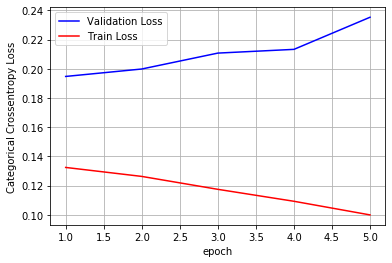

In [17]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

final_output = final_output.append({"Model": 1,
                                    "Architecture": 'Embedding-LSTM-Sigmoid', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["accuracy"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

NameError: ignored